In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import json
from os.path import exists

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [4]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False, directory = '/home/wolfman/Pictures', return_P=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_ind=[]
    params['u_sol']=u
    params['ux']=ux
    params['uy']=uy
    refined=[]
    P=[]
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw();
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig(directory + '/i'+str(i)+'.png',bbox_inches='tight');
            plt.show();
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if i < maxiter-1:
            start=time.time()
            err_ind.append(adap.resPois(MP,uh,f))
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_marking(err_ind[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            MP.h_refine(h_ref=marked_patches, return_P=False)
            end = time.time()
            #print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_ind

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        
        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
            
        if i < maxiter-1:
            start=time.time()
            MP.h_refine(h_ref=-1)
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    #MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [6]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
def ux(x,y):
    r, phi = cart2pol(x,y)
    return -2./3*r**(-1./3)*sin(phi/3)
def uy(x,y):
    r, phi = cart2pol(x,y)
    return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0.

In [14]:
deg=2
M = Lshape(deg,deg+1)
MP, uh, numdofs, L2err, H1err = uniform(M,f={0:f},g=u,u=u, maxiter=7, draw=False)
np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'_uni.txt',np.c_[[numdofs,H1err,L2err]])

Basis setup took 0.007550716400146484 seconds
0
Refinement took 0.0001380443572998047 seconds
Basis setup took 0.006582021713256836 seconds
Refinement took 0.01035308837890625 seconds.
Basis setup took 0.0066394805908203125 seconds
1
Refinement took 0.00012683868408203125 seconds
Basis setup took 0.008620977401733398 seconds
Refinement took 0.012512683868408203 seconds.
Basis setup took 0.009000539779663086 seconds
2
Refinement took 0.00013875961303710938 seconds
Basis setup took 0.015966415405273438 seconds
Refinement took 0.02122044563293457 seconds.
Basis setup took 0.018802881240844727 seconds
3
Refinement took 0.00020360946655273438 seconds
Basis setup took 0.06803250312805176 seconds
Refinement took 0.07815790176391602 seconds.
Basis setup took 0.04393148422241211 seconds
4
Refinement took 0.0001647472381591797 seconds
Basis setup took 0.14647674560546875 seconds
Refinement took 0.1564774513244629 seconds.
Basis setup took 0.14061617851257324 seconds
5
Refinement took 0.000186204

Basis setup took 0.007950782775878906 seconds
0


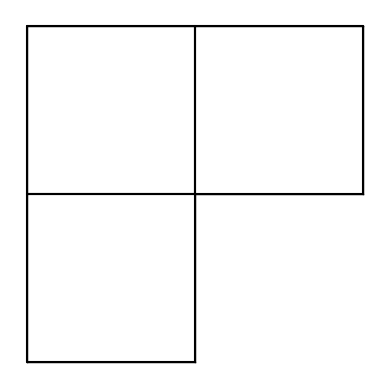

Residual contributions took 0.03458666801452637 seconds.
Jump contributions took 0.013866186141967773 seconds.
Estimate and Marking took 0.048590660095214844 seconds.
Refinement took 0.008699893951416016 seconds for 3 patches.
Basis setup took 0.0074765682220458984 seconds
1


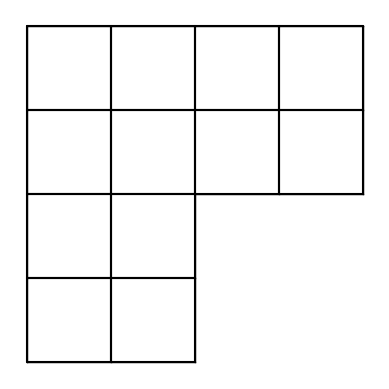

Residual contributions took 0.07624053955078125 seconds.
Jump contributions took 0.0879969596862793 seconds.
Estimate and Marking took 0.16437745094299316 seconds.
Refinement took 0.010405540466308594 seconds for 3 patches.
Basis setup took 0.010571002960205078 seconds
2


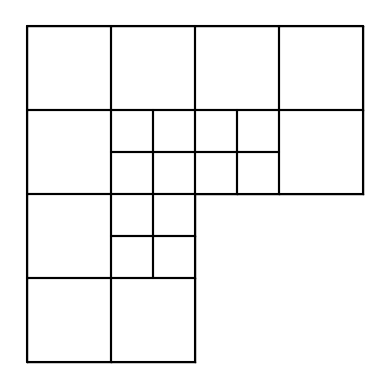

Residual contributions took 0.13451433181762695 seconds.
Jump contributions took 0.19966673851013184 seconds.
Estimate and Marking took 0.33434152603149414 seconds.
Refinement took 0.013706684112548828 seconds for 3 patches.
Basis setup took 0.015095949172973633 seconds
3


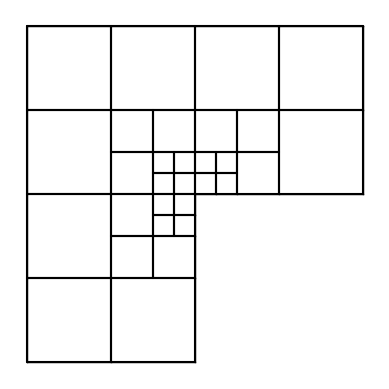

Residual contributions took 0.18717503547668457 seconds.
Jump contributions took 0.3089292049407959 seconds.
Estimate and Marking took 0.49629807472229004 seconds.
Refinement took 0.014387845993041992 seconds for 3 patches.
Basis setup took 0.014733076095581055 seconds
4


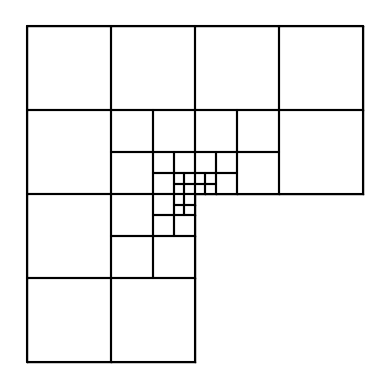

Residual contributions took 0.24353694915771484 seconds.
Jump contributions took 0.4343380928039551 seconds.
Estimate and Marking took 0.6780972480773926 seconds.
Refinement took 0.016374826431274414 seconds for 3 patches.
Basis setup took 0.02064657211303711 seconds
5


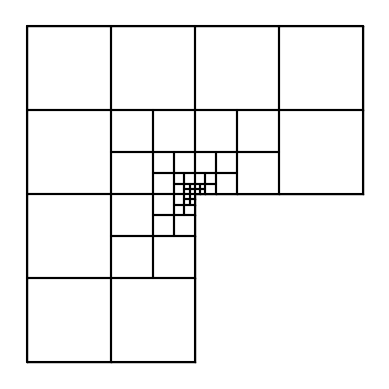

Residual contributions took 0.30176210403442383 seconds.
Jump contributions took 0.5601377487182617 seconds.
Estimate and Marking took 0.8621006011962891 seconds.
Refinement took 0.018762826919555664 seconds for 3 patches.
Basis setup took 0.020269155502319336 seconds
6


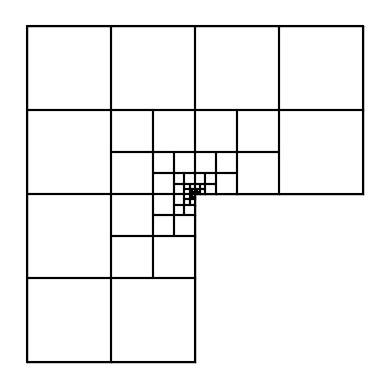

Residual contributions took 0.35448789596557617 seconds.
Jump contributions took 0.6591835021972656 seconds.
Estimate and Marking took 1.013868808746338 seconds.
Refinement took 0.020220279693603516 seconds for 3 patches.
Basis setup took 0.024405717849731445 seconds
7


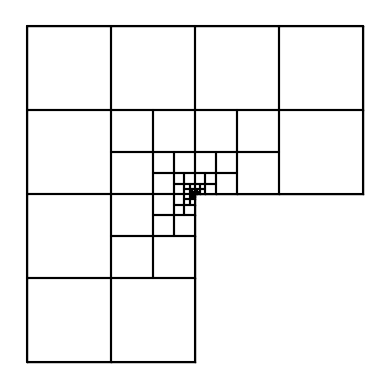

Residual contributions took 0.4106557369232178 seconds.
Jump contributions took 0.7650735378265381 seconds.
Estimate and Marking took 1.175929307937622 seconds.
Refinement took 0.02199268341064453 seconds for 3 patches.
Basis setup took 0.026723146438598633 seconds
8


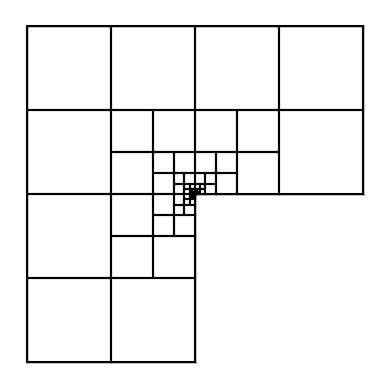

Residual contributions took 0.46724438667297363 seconds.
Jump contributions took 0.8864212036132812 seconds.
Estimate and Marking took 1.3538646697998047 seconds.
Refinement took 0.02389693260192871 seconds for 3 patches.
Basis setup took 0.030041933059692383 seconds
9


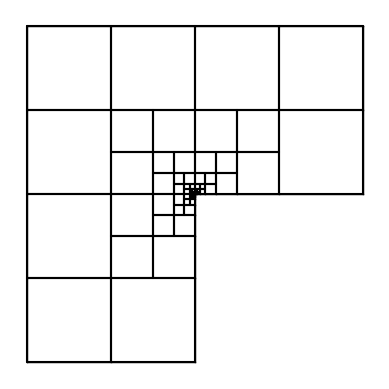

In [7]:
deg=2
M = Lshape(deg,deg+1)
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind = adaptive(M, f={0:f}, g=u, u=u, draw=True, maxiter=10, theta=0.9, directory = '/home/wolfman/Pictures/Lshape_p'+ str(deg))
#M.draw()
np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

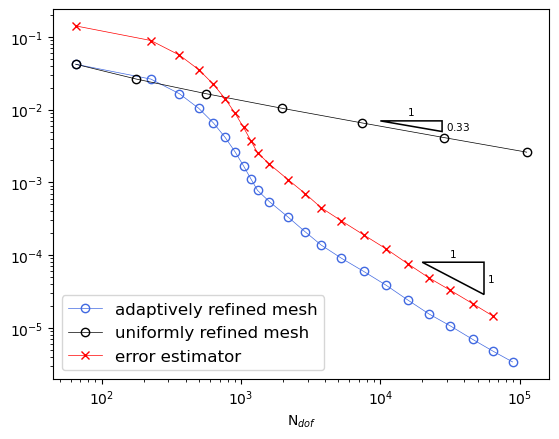

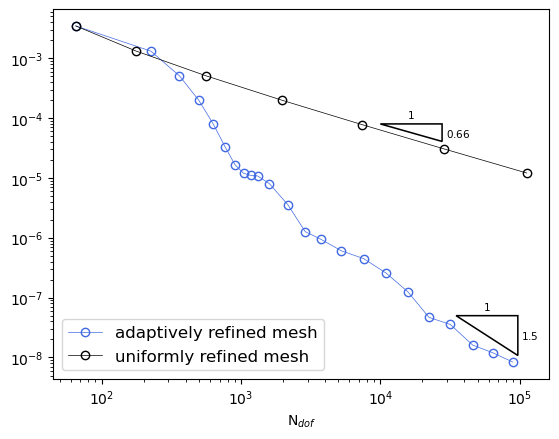

In [126]:
deg=2
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,23))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(2*1e4,0.8*1e-4),2, int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.7*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# ax.set_xlim([1e1,1e5]);
# ax.set_ylim([1e-8,0.3]);
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(3.5*1e4,0.5*1e-7),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.8*1e-4),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

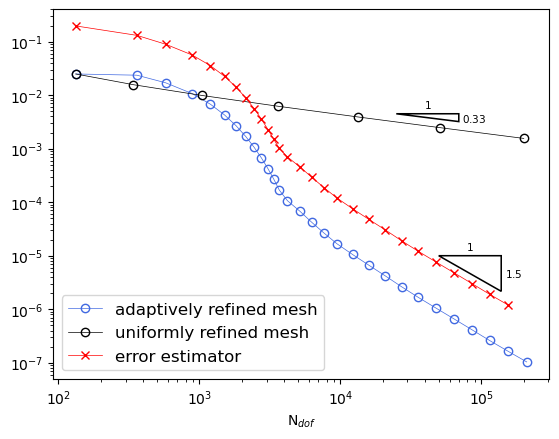

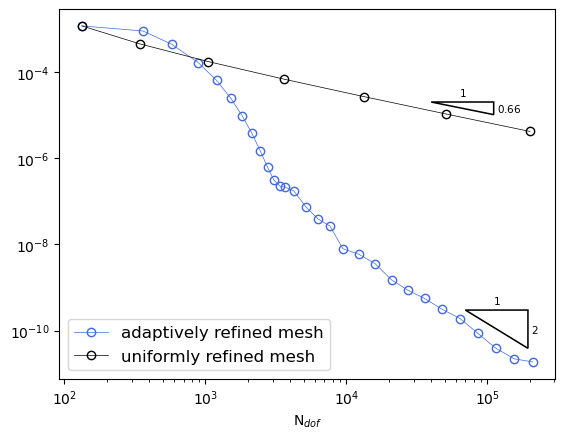

In [ ]:
deg=3
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,29))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.5*1e5,1e-5),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(0.25*1e5,4.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# ax.set_xlim([1,1e7]);
# ax.set_ylim([1e-8,0.3]);
# axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.7*1e5,0.3*1e-9),2,slope=2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(4*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

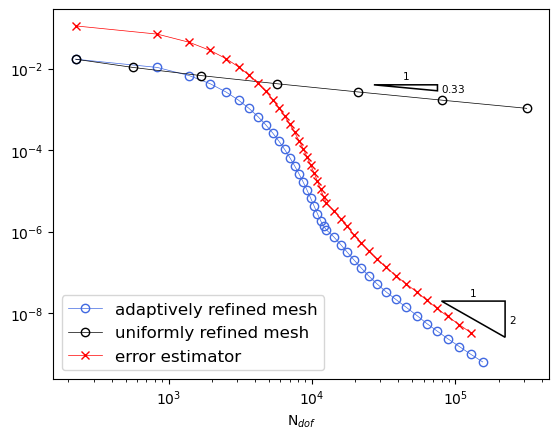

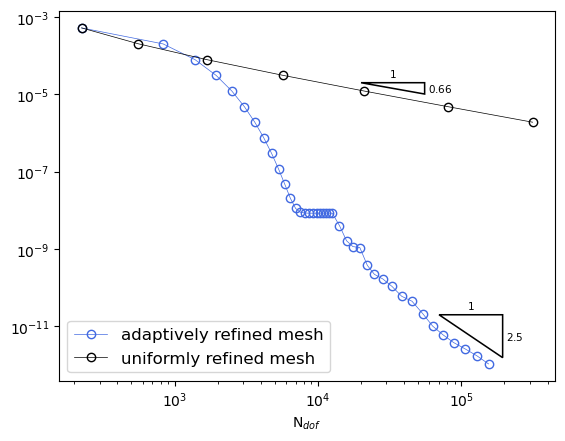

In [130]:
deg=4
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('Lp'+str(deg)+'n'+str(deg+1)+'.txt').reshape((4,40))

fig, ax = plt.subplots()
plt.loglog(numdofs_a, H1err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, H1err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[19:25],[0.2/n**(1) for n in numdofs_a[19:25]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(1/3) for n in numdofs[3:6]],linestyle='--')
#plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 12})
plt.legend(['adaptively refined mesh','uniformly refined mesh','error estimator'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.8*1e5,0.2*1e-7),2,2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2.7*1e4,0.4*1e-2),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a, L2err_a, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs, L2err, 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
draw_loglog_slope(fig,ax,(0.7*1e5,0.2*1e-10),2,slope=2.5,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(2*1e4,2*1e-5),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()